In [19]:
note="hexpaper_fig1inset2"

In [20]:
# This one uses processed Ws inputs, so one does not have to input the array sizes manually
import qpms
from qpms.symmetries import  gen_hexlattice_Kpoint_svwf_rep, gen_hexlattice_Kpoint_svwf_rep_projectors
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate
from scipy.constants import e as eV, hbar, hbar as ℏ, c
ň = np.newaxis
import cmath

In [21]:
evfactor =  (eV/hbar) /( 3e8 / 1e-6 )
evfactor * 1.38, evfactor * 1.5

(6.988630318682703, 7.596337302915982)

In [22]:
Wfile = '/m/phys/project/qd/Marek/fig1_lMax3_cs_200k/roughsteps.002'

In [23]:
#wdata = wdata_long
wdata = qpms.loadWfile_processed(Wfile, lMax=3, midk_halfwidth=None)
lMax = wdata['lMax']
nelem = wdata['nelem']

In [24]:
#wdata.keys(), wdata['nk'], wdata['ks'], wdata['Ws'].shape

In [25]:
#### T-matrices from file
# Original Ag:
TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/cylinder_50nm_lMax3_longer_cleaned.TMatrix'
# Zero loss "Ag":
#TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/zeroloss/cylinder_50nm_lMax2_long.TMatrix'

TMatrices_orig, freqs_orig, freqs_weirdunits_orig, lMaxTM = qpms.loadScuffTMatrices(TMatrix_file, normalisation = 2, version = 'new')
tmtype="Scuff"

In [26]:
# TODO synchronize the TM/W lMaxes better
TMatrices_orig = TMatrices_orig[...,:,0:nelem,:,0:nelem]
lMaxTM = lMax

#### Alternatively, Mie T-matrix
#lMaxTM = force_lMax
lMax = lMaxTM

nelem = lMax * (lMax + 2)
startω =1*eV/ℏ
stopω = 2*eV/ℏ
ωlist = np.linspace(startω, stopω, 200)


ε_b = 2.13
R = 40e-9

if False: # drude model
    ω_p = 9*eV/ℏ #9*eV/ℏ
    ε_inf = 4.6
    γ_p = 0#0.07*eV/ℏ
    
    ε_mlist = qpms.ε_drude(ε_inf, ω_p, γ_p, ωlist)
    tmtype="MieDrude%gnm" % (R/1e-9)
else: # interpolated data
    permdata = np.loadtxt("/u/46/necadam1/unix/tmatrix-experiments/materialy/Au-Johnson-simple.dat")
    permfreqs = permdata[:,0]
    permvals = permdata[:,1] + permdata[:,2]*1j
    permdata_interp = interpolate.interp1d(permfreqs, permvals, axis = 0, kind='linear', fill_value='extrapolate')
    ε_mlist = permdata_interp(ωlist)
    tmtype="MieInterp%gnm" % (R/1e-9)
    

RVlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)
RHlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)

for i in range(len(ωlist)):
    ω=ωlist[i]
    k_i = cmath.sqrt(ε_mlist[i])*ω/c
    k_e = cmath.sqrt(ε_b)*ω/c
    RH, RV, TH, TV = qpms.mie_coefficients(a=R, nmax=lMax, k_i=k_i, k_e=k_e, J_ext=1, J_scat=3)
    RVlist[:,i] = RV
    RHlist[:,i] = RH

y = np.arange(nelem)
my, ny = qpms.get_mn_y(lMax)

TMatrices_orig = np.zeros((RVlist.shape[1], 2, nelem, 2, nelem), dtype=complex)

for l in range(1,lMax+1):
    beg = l**2-1
    end = l*(l+2)
    TMatrices_orig[:,0,beg:end,0,beg:end] = -RVlist[l,:,ň,ň] * np.eye(2*l+1) # FIXME opposite sign?
    TMatrices_orig[:,1,beg:end,1,beg:end] = -RHlist[l,:,ň,ň] * np.eye(2*l+1)

freqs_orig = ωlist

In [85]:
lMax = lMaxTM  # redundant
nelem = qpms.get_nelem(lMax) #redundant
nomega = wdata['nfreqs'] # 286
nk = wdata['nk'] #100
npart = wdata['npart']
wdata['freqs'][0]/(eV/hbar), wdata['freqs'][-1] / (eV/hbar)

(1.315243511856928, 1.5496679626822516)

In [114]:
#nomega, nk, wdata['freqs'][151]/(eV/hbar), wdata['freqs'][-125] / (eV/hbar), wdata['ks'][12][1], wdata['ks'][-33][1]
nomega, nk, wdata['freqs'][151]/(eV/hbar), wdata['freqs'][-125] / (eV/hbar), wdata['ks'][22][1]*4.085/4.199, wdata['ks'][-19][1]*4.085/4.199

(595,
 200,
 1.3748362594573047,
 1.5007308719375712,
 3393257.4160638293,
 4802573.936593119)

In [28]:
#symmetrize TMatrices
yfl = qpms.yflip_tyty(lMax)
xfl = qpms.xflip_tyty(lMax)
zfl = qpms.zflip_tyty(lMax)
TMatrix=TMatrices_orig
TMatrix_sym = (TMatrix + qpms.apply_ndmatrix_left(yfl,qpms.apply_ndmatrix_left(yfl, TMatrix, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(xfl,qpms.apply_ndmatrix_left(xfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(zfl,qpms.apply_ndmatrix_left(zfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
rotN = 600

TMatrix_contribs = np.empty((rotN,)+TMatrix.shape, dtype=np.complex_)
for i in range(rotN):
    rotangle = 2*np.pi*i / rotN
    rot =  qpms.WignerD_yy_fromvector(lMax,np.array([0,0,rotangle]))
    rotinv = qpms.WignerD_yy_fromvector(lMax,np.array([0,0,-rotangle]))
    TMatrix_contribs[i] = qpms.apply_matrix_left(rot,qpms.apply_matrix_left(rotinv, TMatrix_sym, -3),-1)
TMatrix_sym = np.sum(TMatrix_contribs, axis=0) / rotN
TMatrix_sym[np.abs(TMatrix_sym) <= 1e-16] = 0

In [29]:
# TODO process (interpolate and symmetrize) T-matrix here
TMatrices_interp = interpolate.interp1d(freqs_orig, TMatrix_sym, axis = 0, kind='linear', fill_value='extrapolate')


In [30]:
Wmatrices = wdata['Ws'].reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#Wmatrices = (wdata_long['Ws']+0*wdata_short['Ws']).reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#TMatrices = TMatrix_sym.reshape((nomega,1,2,nelem,2,nelem))
ks = np.broadcast_to(wdata['ks'][ň,:,:], (nomega, nk, 2))
freqs = np.broadcast_to(wdata['freqs'][:,ň], (nomega,nk))

Wmatrices.shape, ks.shape, freqs.shape


((595, 200, 2, 2, 15, 2, 2, 15), (595, 200, 2), (595, 200))

In [31]:
TMatrices_orig.shape, ks.shape, freqs.shape

((158, 2, 15, 2, 15), (595, 200, 2), (595, 200))

# Full problem
TE_or_TM = None # just that the scripts below know...
allU = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allV = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allS = np.full((nomega,nk,npart*2*nelem), np.nan)
for omi in range(nomega):
    for ki in range(nk):
        W = Wmatrices[omi,ki]
        T = TMatrices_interp(freqs[omi,ki]) * 1
        TW = np.sum(
            T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
        , axis = (-5,-4))
        iden = np.eye(npart*2*nelem)
        iden.shape = (npart,2,nelem,npart,2,nelem)
        finalMatrix = iden-TW
        try:
            allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*2*nelem,npart*2*nelem)), 
                                                                        lapack_driver= 'gesvd')
        except ValueError:
            pass
restype="Full"                

In [32]:
# Z-symmetric problem
TE_or_TM = 0 # 0 is TE

TE_yz = np.arange(nelem)
TM_yz = TE_yz
my, ny = qpms.get_mn_y(lMax)
TE_NMz = (my + ny) % 2
TM_NMz = (1 - TE_NMz)
T_NMz = TE_NMz if TE_or_TM == 0 else TM_NMz
T_yz = TE_yz if TE_or_TM == 0 else TM_yz
y = np.arange(nelem)
yi = y[ň,ň,ň,:]
yj = y[ň,:,ň,ň]
ipart = np.arange(npart)
ti = np.arange(2)

#allU = np.full((nomega,nk,npart*nelem,npart*nelem), np.nan, dtype=complex)
#allV = np.full((nomega,nk,npart*nelem,npart*nelem), np.nan, dtype=complex)
allS = np.full((nomega,nk,npart*nelem), np.nan)
for omi in range(nomega):
    for ki in range(nk):
        W = Wmatrices[omi,ki][..., ipart[:,ň,ň,ň], T_NMz[ň,:,ň,ň],T_yz[ň,:,ň,ň], ipart[ň,ň,:,ň], T_NMz[ň,ň,ň,:],T_yz[ň,ň,ň,:]] # [Npart,2,nelem,Npart,2,nelem] -> [Npart,nelem,Npart,nelem]
        W[np.isclose(W,0, atol = 1e-10)] = 0
        T = TMatrices_interp(freqs[omi,ki])[...,T_NMz[:,ň],T_yz[:,ň],T_NMz[ň,:],T_yz[ň,:]]  #[2,nelem,2,nelem] -> [nelem,nelem]
        TW = np.sum(
            T[...,ň,:,:,ň,ň] * W[...,:,ň,:,:,:]
        , axis = (-3))
        iden = np.eye(npart*nelem)
        iden.shape = (npart,nelem,npart,nelem)
        finalMatrix = iden-TW
        try:
            #allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), 
            allS[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), compute_uv = False,
                                                                       # lapack_driver= 'gesvd'
                                                                       )
        except ValueError:
            pass

#theV = allV[:,:,sorder,:].reshape(nomega,nk,2,2,nelem)
#allV_expanded = np.zeros((nomega,nk,npart*nelem,2,2,nelem),dtype=complex)
#for t in (0,1):
#    allV_expanded[:,:,:,:,t,T_NMz == t]  = allV.reshape((nomega,nk,npart*nelem,npart,nelem))[:,:,:,:,T_NMz == t]

if TE_or_TM == 0:
    restype="E-inplane"
elif TE_or_TM == 1:
    restype="M-inplane"
else:
    restype="WTF"

In [33]:
allS.shape

(595, 200, 30)

In [58]:
%matplotlib inline
def make_image(data, outputname, size=(1.1, 1.5), dpi=300):
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    #plt.set_cmap('hot')
    ax.pcolormesh(data, #aspect='equal'
             )
    plt.savefig(outputname, dpi=dpi)

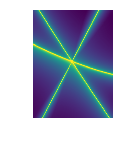

In [116]:
#make_image(np.clip(np.log(1-allS[151:-125,12:-33,-1]), -11, -2), "figs/lMax%d%s%s%s_disp_big_n.pdf"%(lMax,tmtype,restype,note), dpi=900)
make_image(np.clip(np.log(1-allS[151:-125,22:-19,-1]), -11, -2), "figs/lMax%d%s%s%s_disp_big_n.png"%(lMax,tmtype,restype,note), dpi=900) # posun k-bodu na špatně zkalibrované měření

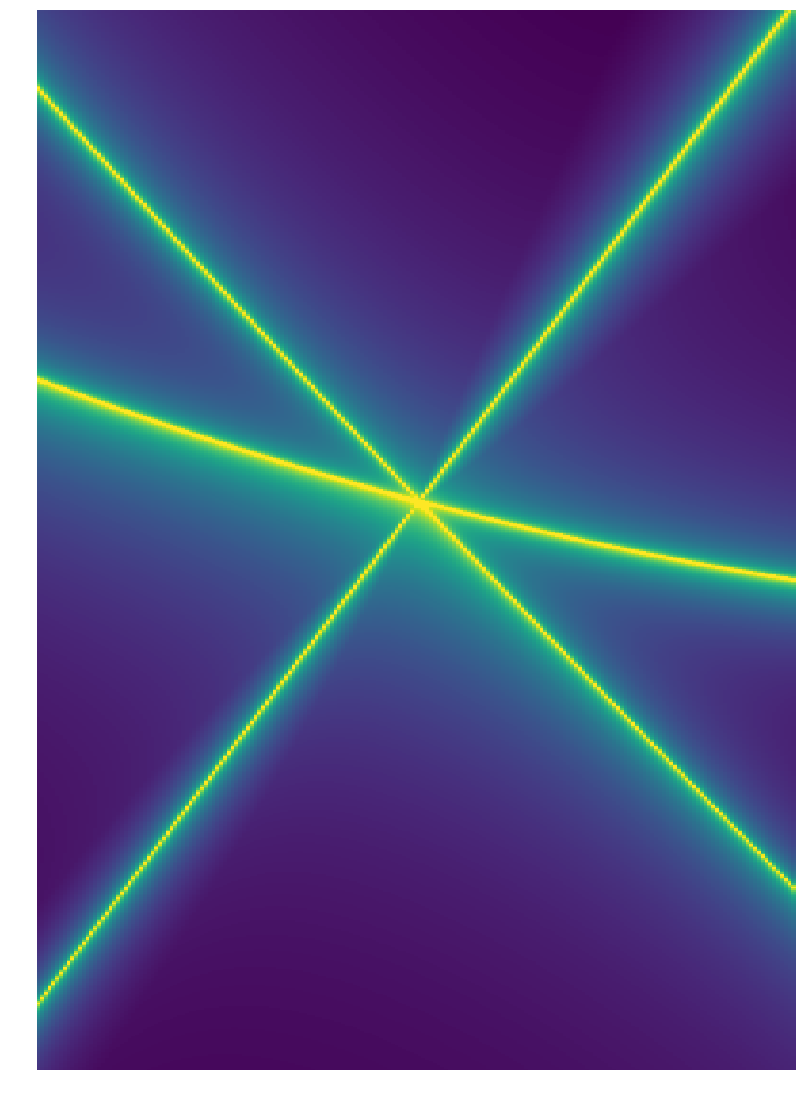

In [50]:
%matplotlib inline
plot_margin=0
#plt.figure(figsize=(2.25,3.75))
plt.figure(figsize=(11,15))
#plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, allS[:,:,-1])
#plt.imshow(np.clip(np.log(1-allS[:,:,-1]),-11.5,-3.8), origin = 'lower')
plt.pcolormesh(ks[:,:,1], freqs[:,:]*hbar/eV, np.clip(np.log(1-allS[:,:,-1]), -11, -2))

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))
plt.axis('off')
#plt.colorbar()
plt.tight_layout(pad=0)
plt.savefig("figs/lMax%d%s%s%s_dispbg.png"%(lMax,tmtype,restype,note), #bbox_inches='tight'
           )